In [4]:
import re
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, desc, row_number, monotonically_increasing_id
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover
from pyspark.sql.window import Window
from textblob import TextBlob
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt

In [5]:
spark =SparkSession.builder.appName('SparkProject').config("spark.executor.memoryOverhead", "50g").getOrCreate() 

In [6]:
df = spark.read.json("tweet_electricvehicles.json")

22/12/04 11:17:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df = df.dropDuplicates(['id'])
df = df.filter("rawContent != ''")

In [8]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_number(string):
    string = re.sub('([0-9]+)', '', string)
    return string

def remove_users(string):
    string = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', string) 
    string = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', string) 
    return string

In [9]:
remove_emoji=udf(remove_emoji)
remove_users=udf(remove_users)
remove_number=udf(remove_number)

df=df.withColumn('rawContent', remove_emoji(df['rawContent']))
df=df.withColumn('rawContent', remove_users(df['rawContent']))
df=df.withColumn('rawContent', remove_number(df['rawContent']))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', r'http\S+', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '@\w+', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '#', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', 'RT', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', ':', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '\n', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '|', ''))
df = df.withColumn('rawContent', F.regexp_replace('rawContent', '[^\sa-zA-Z0-9]', ''))
df = df.withColumn("rawContent",F.lower('rawContent'))
df = df.withColumn("rawContent",F.rtrim('rawContent'))

df = df.withColumn('Tweet_No', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)


In [10]:
#Tokenizing the Raw Content
tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("rawContent").setOutputCol("tokens")
df = tokenizer.transform(df)

In [11]:
#Removing Stopwords
nltk.download('stopwords')
stopwordList = stopwords.words('english')
remover = StopWordsRemover(stopWords=stopwordList)
remover.setInputCol("tokens")
remover.setOutputCol("filtered")
df = remover.transform(df)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phanithdsv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#Lemmentization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatization(row):
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row

lemmatization = udf(lemmatization)
df=df.withColumn('tokens', lemmatization(df['filtered']))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phanithdsv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
#Extracting Sentiments from the tweet
sentiment_polarity = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment_polarity", sentiment_polarity)
df = df.withColumn('sentiment_polarity',sentiment_polarity('rawContent').cast('double'))

sentiment_subjectivity = udf(lambda x: TextBlob(x).sentiment[1])
spark.udf.register("sentiment_subjectivity", sentiment_subjectivity)
df = df.withColumn('sentiment_subjectivity',sentiment_subjectivity('rawContent').cast('double'))


In [14]:
# Extracting raw content values
rawContents = df.select("rawContent").rdd.flatMap(lambda x: x).collect()

# Extracting tokenized filtered content values
filteredContents = df.select("filtered").rdd.flatMap(lambda x: x).collect()

In [15]:
# Function to create the eta for topic modelling
def create_eta(topics, dictionary):
    eta = np.full(shape=(len(topics), len(dictionary)), fill_value=1) 
    for word, topic in topics.items():
        keyindex = [index for index,term in dictionary.items() if term==word] 
        if (len(keyindex)>0): 
            eta[topic,keyindex[0]] = 1e7 
    eta = np.divide(eta, eta.sum(axis=0)) 
    return eta

In [16]:
# Function to create and run the guided lda model
def test_eta(eta, dictionary):
    corp = filteredContents
    np.random.seed(42) 
    bow = [dictionary.doc2bow(line) for line in corp] 
    with (np.errstate(divide='ignore')):  
        model = LdaModel(
            corpus=bow, id2word=dictionary, num_topics=eta.shape[0],
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    return model

In [17]:
topic_labelling = {
    'cost': 0,'value': 0,'worth': 0,'valuation': 0,'premium': 0,'rate': 0,'overprice': 0,'cheap': 0,'discount': 0,'inflation': 0,'pay': 0,'amount': 0,'expense': 0,'expensive': 0,'dollar': 0,'money': 0,'costly': 0,'prise': 0,'priceless': 0,'undervalue': 0,'overvalue': 0,'revaluation': 0,'pennyworth': 0,'economy': 0,'underrate': 0,'underprice': 0,'profit': 0,'estimate':0 ,'fees':0 ,'marginal':0 ,'cash':0 ,'pocket':0 ,'capital':0 ,'dime':0 ,'markup':0 ,'haggle':0 ,'wholesale':0 ,'quotation':0 ,'stipend':0 ,'afford':0 ,'savings':0 ,'save':0,'range':1 ,'anxiety':1 ,'far':1 ,'distance':1 ,'long':1 ,'area':1 ,'long-range':1 ,'short-range':1 ,'travel':1 ,'near':1 ,'mileage':1 ,'afar':1 ,'farther':1 ,'reach':1 ,'remote':1 ,'short':1 ,'stretch':1 ,'haul':1 ,'distant':1 ,'commute':1 ,'extended-range':1,'fuel':2 ,'zero':2 ,'emission':2 ,'das':2 ,'diesel':2 ,'refuel':2 ,'coal':2 ,'oil ':2 ,'charcoal':2 ,'biogas':2 ,'fossil':2 ,'electric':2 ,'ev':2,'eco':3 ,'eco-friendly':3 ,'carbon':3 ,'footprint':3 ,'pollution':3 ,'sustainable':3 ,'renewal':3 ,'power':3 ,'plug':3 ,'green':3 ,'environment':3 ,'earth':3 ,'friendly':3 ,'carbon':3 ,'footprint':3,'batttery':4 ,'cell':4 ,'life':4 ,'charge':4 ,'charger':4 ,'voltage':4 ,'elctrolyte':4 ,'surcharge':4 ,'lithium-ion':4 ,'lithium':4 ,'ion':4 ,'battery cost':4 ,'battery life':4 ,'Fuel cell':4 ,'killowatt':4 ,'hour':4 ,'killowatt-hour':4 ,'regenerative':4 ,'regenerative-braking':4, 'infra':5 ,'infrastructure':5 ,'stations':5 ,'charging':5 ,'plug':5 ,'chademo':5 ,'fast charging':5 ,'supercharger':5 ,'framework':5 ,'structure':5 ,'groundwork':5 ,'support':5
}
dictionary = corpora.Dictionary(filteredContents)
eta = create_eta(topic_labelling, dictionary)
lda_model = test_eta(eta, dictionary)

In [18]:
def format_topics_sentences(lda_model, corpus, rawContents):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(rawContents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

corpus = [dictionary.doc2bow(words) for words in filteredContents]
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus, rawContents)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Tweet_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tweet']

/var/folders/hb/h9nbyj456fs5m9jgzhd_g7y40000gn/T/ipykernel_20209/1586861331.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [19]:
df_dominant_topic.head(10)

,Tweet_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tweet
0,0,92,0.2423,"december, set, charger, fast, installation, co...",hypercharge to complete st dc fast charger ins...
1,1,66,0.2749,"electricvehicles, electric, car, says, global,...",electricvehicles evs ces
2,2,54,0.3118,"lithium, batterymetals, learn, recharge, resou...",recharge resources is uniquely positioned and ...
3,3,66,0.4526,"electricvehicles, electric, car, says, global,...",introducing our new virtual electric car brand...
4,4,110,0.2568,"motors, motorcycle, speed, adventure, nascar, ...",motors high octane amp a need for speed zoom ...
5,5,66,0.2820,"electricvehicles, electric, car, says, global,...",straightening the truthnft newnft utility util...
6,6,53,0.2098,"green, best, winter, robot, deals, style, digi...",the best style in winter is warmth dress appro...
7,7,66,0.2151,"electricvehicles, electric, car, says, global,...",matter unveils indias first electric motorcycl...
8,8,66,0.2425,"electricvehicles, electric, car, says, global,...",the mitmobility forum dec electric vehicle p...
9,9,66,0.2413,"electricvehicles, electric, car, says, global,...",avatar the way of water and avatarthewayofwa...


In [20]:
# Calculating Sentiment for each Tweet

dominant_topic=spark.createDataFrame(df_dominant_topic)
join = df.join(dominant_topic, dominant_topic.Tweet_No == df.Tweet_No, 'left').select(dominant_topic.Tweet_No, dominant_topic.Dominant_Topic,dominant_topic.Tweet,df.sentiment_polarity,df.sentiment_subjectivity)

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [21]:
# Adding new Sentiment column to our data
df3 = join.withColumn("Sentiment", when(join.sentiment_polarity > 0, 1).when(join.sentiment_polarity < 0, -1).otherwise(0))

In [22]:
df3 .show()

22/12/04 11:34:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+--------------+--------------------+--------------------+----------------------+---------+
|Tweet_No|Dominant_Topic|               Tweet|  sentiment_polarity|sentiment_subjectivity|Sentiment|
+--------+--------------+--------------------+--------------------+----------------------+---------+
|      19|            66|heres how deep ge...| 0.12222222222222223|    0.4083333333333334|        1|
|       0|            92|hypercharge to co...| 0.15000000000000002|                   0.5|        1|
|       7|            66|matter unveils in...|                0.25|    0.3333333333333333|        1|
|       6|            53|the best style in...|  0.6333333333333333|   0.43333333333333335|        1|
|       9|            66|avatar the way of...|                 0.0|                   0.0|        0|
|      17|            66|porsche taycan le...|                 0.0|                   0.0|        0|
|       5|            66|straightening the...|                 0.0|                   0.0| 

In [23]:
dominantTopicsCount = df3.groupBy("Dominant_Topic").count()
dominantTopicsCount = dominantTopicsCount.orderBy(col("Dominant_Topic").asc())

sentimentcount = df3.groupBy("Sentiment").count()
sentimentcount = sentimentcount.orderBy(col("Sentiment").asc())

22/12/04 11:34:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 11:34:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/04 1

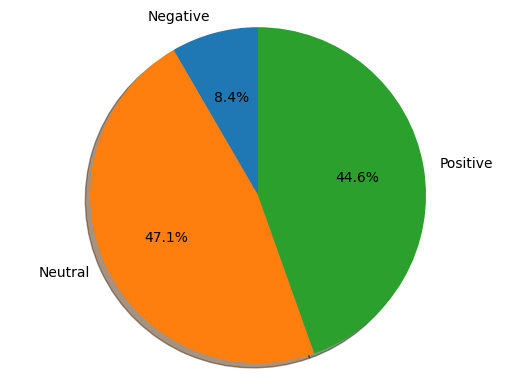

In [24]:
labels = ['Negative','Neutral','Positive']
listValues = list(sentimentcount.select('count').toPandas()['count'])
sum = 0
for item in listValues:
   sum += item
    
print(sum)
print(listValues)
listValues = [(number / sum)*100 for number in listValues]
print(listValues)
fig1, ax1 = plt.subplots()
ax1.pie(listValues, labels=labels ,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

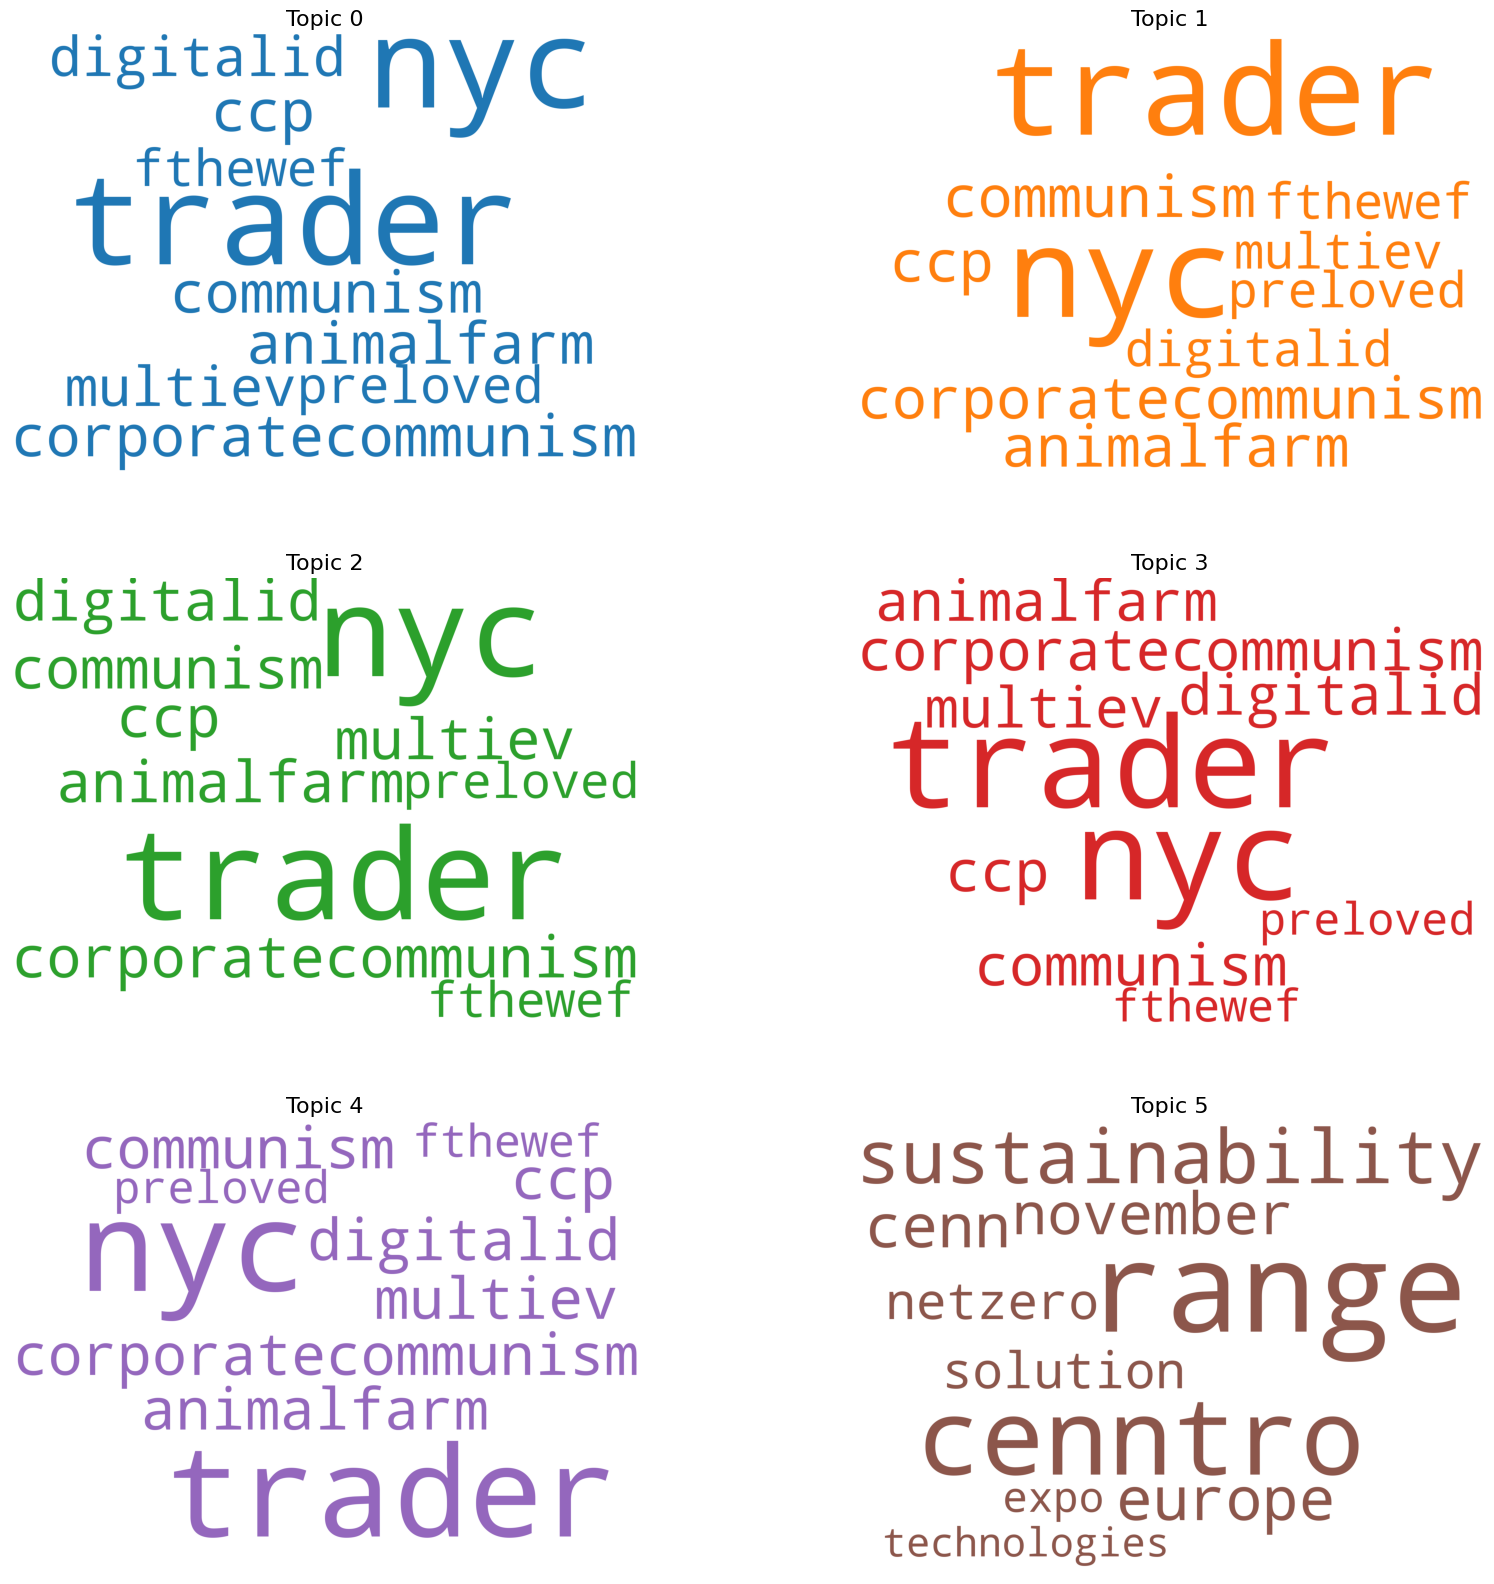

In [25]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwordList,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In [ ]:
data_lemmatized = filteredContents
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3001145514426568
